In [1]:
# import sys
# !{sys.executable} -m pip install mpl_toolkits

In [1]:
import glacierml as gl
import configparser
import matplotlib.pyplot as plt
# from mpl_toolkits.basemap import Basemap
import numpy as np
import pandas as pd
from tqdm import tqdm
pd.set_option('display.max_column',None)
# import sys
cols = []
for i in range(273):
    cols.append(i)
# !{sys.executable} -m pip install basemap

2024-04-26 20:36:43.630567: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-26 20:36:43.670819: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-26 20:36:43.671870: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-26 20:36:44.434475: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
home_path = '/home/simonhans/glacierml'
[
        data_path, RGI_path, glathida_path, ref_path,
        coregistration_testing_path, 
        arch_test_path, LOO_path
] = gl.set_paths(home_path)

#### Let's look at how we compare to Farinotti et al. 2019

In [3]:
df = pd.read_pickle('final.pkl')

In [4]:
shelves = df[df['TermType'] == 5]

In [5]:
len(shelves)

169

In [6]:
# df = pd.read_pickle('/data/fast1/glacierml/data/final_df.pkl')
E_A = df['Area']
E_H = np.mean(df[cols],axis = 1)
si = df['sig_k_ind'] # = (Var(H)*Var(A) + A^2Var(H) + H^2Var(A))

sp = np.sum(si)

se = np.sqrt(sp)

Z = (1.96)
Vlb = np.round( (np.sum(E_H * E_A) - (Z*se)) , 0) / 1e3
Vub = np.round( (np.sum(E_H * E_A) + (Z*se)) , 0) / 1e3

print(f'[{Vlb},{Vub}]  * 10^3 km^3')

print(f'Mid CI: {np.round((Vub + Vlb) / 2,3)} * 10^3 km^3')

print(f'CI Half Width: {np.round((Vub - Vlb) / 2,3)} * 10^3 km^3')

[133.17,138.06]  * 10^3 km^3
Mid CI: 135.615 * 10^3 km^3
CI Half Width: 2.445 * 10^3 km^3


#### Okay, that is our global sum. Now lets look at our global sum when just comparing to Millan. To accomplish this, we exclude shelf supported glaciers in Antarctica 

In [7]:
# df = pd.read_pickle('/data/fast1/glacierml/data/final_df.pkl')

df_no_shelf = df.drop(df[
    (df['TermType'] == 5) & (df['region'] == '19')
].index)

# df = pd.read_pickle('/data/fast1/glacierml/data/final_df.pkl')
E_A = df_no_shelf['Area']
E_H = np.mean(df_no_shelf[cols],axis = 1)
si = df_no_shelf['sig_k_ind'] # = (Var(H)*Var(A) + A^2Var(H) + H^2Var(A))

sp = np.sum(si)

se = np.sqrt(sp)

Z = (1.96)
Vlb = np.round( (np.sum(E_H * E_A) - (Z*se)) , 0) / 1e3
Vub = np.round( (np.sum(E_H * E_A) + (Z*se)) , 0) / 1e3

print(f'[{Vlb},{Vub}]  * 10^3 km^3')

print(f'Mid CI: {np.round((Vub + Vlb) / 2,3)} * 10^3 km^3')

print(f'CI Half Width: {np.round((Vub - Vlb) / 2,3)} * 10^3 km^3')

[109.38,113.359]  * 10^3 km^3
Mid CI: 111.369 * 10^3 km^3
CI Half Width: 1.989 * 10^3 km^3


In [8]:
140.6 - 111.399

29.200999999999993

#### Interesting, now how do we compare to Farinotti?

In [9]:
df = pd.read_pickle('final.pkl')
cols,dft = gl.load_LOO_data(home_path,include_refs = True)
df = pd.merge(df,dft,how = 'inner', on = list(dft)[:-1])
E_A = df['Area']
E_H = np.mean(df[cols],axis = 1)
si = df['sig_k_ind'] # = (Var(H)*Var(A) + A^2Var(H) + H^2Var(A))

sp = np.sum(si)

se = np.sqrt(sp)

Z = (1.96)
Vlb = np.round( (np.sum(E_H * E_A) - (Z*se)) , 0) / 1e3
Vub = np.round( (np.sum(E_H * E_A) + (Z*se)) , 0) / 1e3

print(f'[{Vlb},{Vub}]  * 10^3 km^3')

print(f'Mid CI: {np.round((Vub + Vlb) / 2,3)} * 10^3 km^3')

print(f'CI Half Width: {np.round((Vub - Vlb) / 2,3)} * 10^3 km^3')

[119.547,124.08]  * 10^3 km^3
Mid CI: 121.814 * 10^3 km^3
CI Half Width: 2.267 * 10^3 km^3


In [10]:
158.48 - 121.81

36.66999999999999

#### We are looking for $\approx 36.7 \times 10^3 \text{km}^3$

In [11]:
df = pd.concat(
    [
        df,
        pd.Series( (np.mean(df[cols],axis = 1) * df['Area'] )- (df['FMT'] * df['Area']), name = 'r' )
    ], axis = 1
)


Text(0.5, 1.0, 'Cumulative Sum Difference of Volumes')

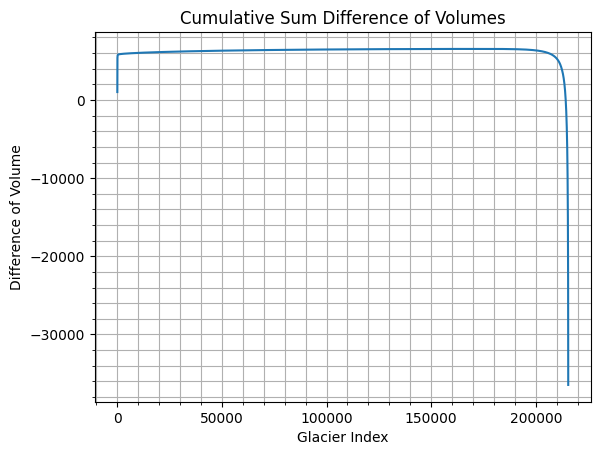

In [14]:
running_sum = np.cumsum(
    df['r'].sort_values(ascending = False).reset_index().drop('index',axis = 1)
)
running_sum.index = range(1, len(running_sum) + 1)

plt.plot(running_sum)
plt.minorticks_on()
plt.grid(which = 'both')
plt.xlabel('Glacier Index')
plt.ylabel('Difference of Volume')
plt.title('Cumulative Sum Difference of Volumes')

#### Okay, so we have a handful of large positive and large negative discrepancies. 
#### What do they look like close up?

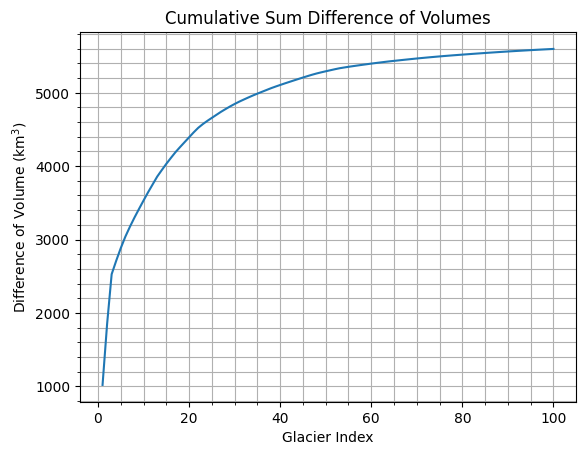

In [16]:
running_sum1 = np.cumsum(
    df['r'].sort_values(ascending = False).reset_index().drop('index',axis = 1)
)
running_sum1.index = range(1, len(running_sum1) + 1)

plt.plot(running_sum1[0:100])
plt.minorticks_on()
plt.grid(which = 'both')
# plt.xscale('log')
plt.xlabel('Glacier Index')
plt.ylabel('Difference of Volume (km$^3$)')
plt.title('Cumulative Sum Difference of Volumes')
plt.show()

Text(0.5, 1.0, 'Cumulative Sum Difference of Volumes')

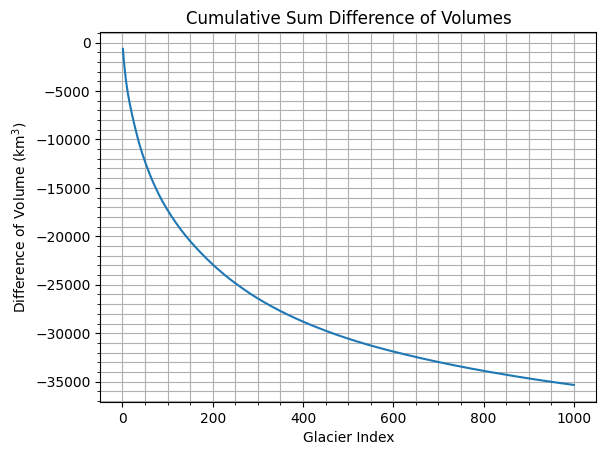

In [18]:
running_sum2 = np.cumsum(
    df['r'].sort_values(ascending = True).reset_index().drop('index',axis = 1)
)
running_sum2.index = range(1, len(running_sum2) + 1)
# plt.plot(running_sum1[0:500],label = 'Positive Differences')

plt.plot(running_sum2[0:1000],label = 'Negative Differences')
plt.minorticks_on()
plt.grid(which = 'both')
# plt.xscale('log')
# plt.legend()
plt.xlabel('Glacier Index')
plt.ylabel('Difference of Volume (km$^3$)')
plt.title('Cumulative Sum Difference of Volumes')

Text(0.5, 1.0, 'Cumulative Sum Difference of Volumes')

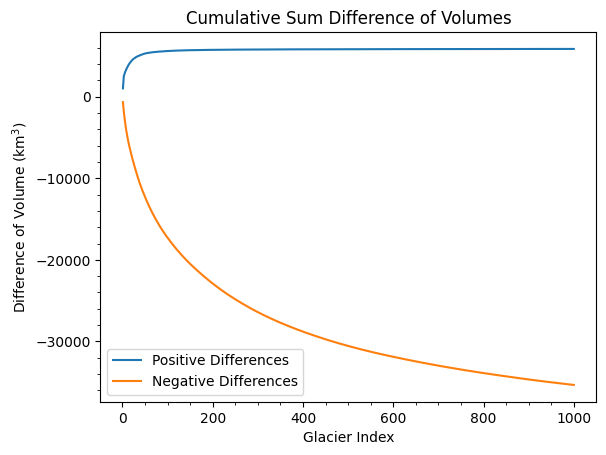

In [20]:
running_sum2 = np.cumsum(
    df['r'].sort_values(ascending = True).reset_index().drop('index',axis = 1)
)
running_sum2.index = range(1, len(running_sum2) + 1)
plt.plot(running_sum1[0:1000],label = 'Positive Differences')

plt.plot(running_sum2[0:1000],label = 'Negative Differences')
plt.minorticks_on()
# plt.grid(which = 'both')
# plt.xscale('log')
plt.legend()
plt.xlabel('Glacier Index')
plt.ylabel('Difference of Volume (km$^3$)')
plt.title('Cumulative Sum Difference of Volumes')

#### What percentage of the global glacier volume discrepancy can be accounted for with these glaciers?

In [21]:
df1 = df.sort_values('r', ascending=True)
df2 = df.sort_values('r', ascending=True)

In [23]:
counts = []
percs = []
n = 0
for i in tqdm(range(10,540,10)):
#     print(i)
    n =+ i
#     print(n*2)

    percent_of_df = np.round((n*2) / len(df) * 100,4)
#     print(f'Percent of global glaciers considered = {percent_of_df}')

    neg = (np.sum(df1['r'].head(n)) / 1e3)
#     print(neg)

    pos = (np.sum(df2['r'].tail(n)) / 1e3)
    d = abs(pos + neg) / (-t) * 100
    percs.append(d)
    counts.append(percent_of_df)
#     print(f'Volume Difference contained = {d}')
#     print('')

  0%|                                                    | 0/53 [00:00<?, ?it/s]


NameError: name 't' is not defined

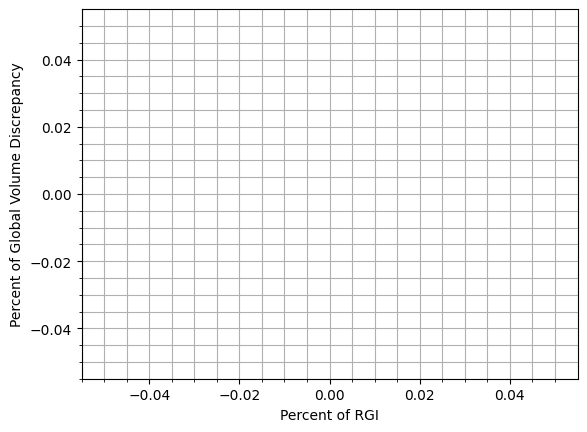

In [24]:
plt.plot(counts,percs)
plt.xlabel('Percent of RGI')
plt.ylabel('Percent of Global Volume Discrepancy')
plt.minorticks_on()
plt.grid(which = 'both')

In [ ]:
RGI = gl.load_RGI()

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20, 20))

ax1 = axes[0]
m1 = Basemap(projection='cyl', ax=ax1, resolution='c')
m1.scatter(RGI['CenLon'], RGI['CenLat'], c='blue', alpha=0.5, label='RGI Outline')

m1.scatter(df1['CenLon'].head(500), df1['CenLat'].head(500), c='red', alpha=1, label='Largest Negative Differences')
m1.drawcoastlines()
ax1.legend(bbox_to_anchor=(0.25, 0.56), facecolor='w', framealpha=1, fontsize=15)

ax2 = axes[1]
m2 = Basemap(projection='cyl', ax=ax2, resolution='c')
m2.scatter(RGI['CenLon'], RGI['CenLat'], c='blue', alpha=0.5, label='RGI Outline')

m2.scatter(df2['CenLon'].tail(500), df2['CenLat'].tail(500), c='orange', alpha=1, label='Largest Positive Differences')
m2.drawcoastlines()
ax2.legend(bbox_to_anchor=(0.25, 0.56), facecolor='w', framealpha=1, fontsize=15)

plt.show()

In [ ]:
neg_100 = df1.head(100)
pos_100 = df1.tail(100)

In [ ]:
g = gl.coregister_data('4')

g = g.drop(g[g['RGIId'].duplicated(keep = False)].index)
g = g.sample(frac = 1,random_state = 0)
g = g.reset_index().drop('index', axis = 1)
g['region'] = g['RGIId'].str[6:8]

In [ ]:
for i in neg_100['region'].sort_values().unique():
    negs = neg_100[neg_100['region'] == i]
    category_to_count = i
    n = (neg_100['region'] == category_to_count).sum()
    
    category_to_count2 = 5
    m = (negs['TermType'] == category_to_count2).sum()
    
    category_to_count2 = 1
    l = (negs['Form'] == category_to_count2).sum()
    
    search_list = np.ndarray.tolist(negs['RGIId'].values)
    pattern = '|'.join(search_list)
    gs = g[g['RGIId'].str.contains(pattern)]
    o = g['RGIId'].str.contains(pattern).sum()   
    print(
        f'RGI Region {i} has {n} / 500 most negative discrepant glaciers,\n'
        f'{m} of which are shelf supported,\n'
        f'{l} of which are ice caps,\n'
        f'{o} of which are in training data.'
    )
    if o != 0:
        
    
        category_to_count3 = 5
        category_to_count4 = 1
        p = (gs['TermType'] == category_to_count3).sum()
        q = (gs['Form'] == category_to_count4).sum()   
        print(
            f'Of the glaciers contained in training data, '
            f'{p} are shelf supported and {q} are ice caps'
        )
        problem_train_glacs = gs['Name'].values
        problem_train_glacs_id = gs['RGIId'].values
        print(f'These glaciers are {problem_train_glacs}')
        print(f'RGIId: {problem_train_glacs_id}')
    print('')

In [ ]:
g

In [ ]:
plt.scatter(g['Area'],g['Area']*(g['Thickness']/1e3))
plt.xscale('log')
plt.yscale('log')

In [ ]:
sum(df['r'][df['TermType'] == 5]) / 1e3

In [ ]:
len(g[g['TermType'] == 1])

In [ ]:
dfr0 = (df[(df['TermType'] == 1) & (df['Form'] == 1)])
dfr1 = (df[(df['TermType'] == 5) & (df['Form'] == 1)])

In [ ]:
dfr0 = (df[
    (df['TermType'] == 1) & 
#     (df['Form'] == 0) & 
    (df['region'] == '07')
])
dfr0 = (df[
    (df['TermType'] == 5) & 
#     (df['Form'] == 0) & 
    (df['region'] == '07')
])


In [ ]:
# plt.scatter(dfr0['Area'],-dfr0['r'])
plt.scatter(dfr0['Area'],dfr0['r'])
plt.xscale('log')
plt.yscale('log')

In [ ]:
plt.scatter(dfr1['Area'],-dfr1['r'])

plt.scatter(dfr1['Area'],dfr1['r'])
plt.xscale('log')
plt.yscale('log')

In [ ]:
dfr1

In [ ]:
(df['r'][(df['TermType'] == 1) & (df['region'] == '05')])

In [ ]:
(df['r'][(df['TermType'] == 0) & (df['region'] == '05')])

In [ ]:
for i in pos_100['region'].sort_values().unique():
    poss = pos_100[pos_100['region'] == i]
    category_to_count = i
    n = (pos_100['region'] == category_to_count).sum()
    
    category_to_count2 = 5
    m = (poss['TermType'] == category_to_count2).sum()
    
    category_to_count2 = 1
    l = (poss['Form'] == category_to_count2).sum()
    
    search_list = np.ndarray.tolist(poss['RGIId'].values)
    pattern = '|'.join(search_list)
    gs = g[g['RGIId'].str.contains(pattern)]
    o = g['RGIId'].str.contains(pattern).sum()   
    print(
        f'RGI Region {i} has {n} / 500 most positive discrepant glaciers,\n'
        f'{m} of which are shelf supported,\n'
        f'{l} of which are ice caps,\n'
        f'{o} of which are in training data.'
    )
    if o != 0:
        
    
        category_to_count3 = 5
        category_to_count4 = 1
        p = (gs['TermType'] == category_to_count3).sum()
        q = (gs['Form'] == category_to_count4).sum()   
        print(
            f'Of the glaciers contained in training data, '
            f'{p} are shelf supported and {q} are ice caps'
        )
        problem_train_glacs = gs['Name'].values
        problem_train_glacs_id = gs['RGIId'].values
        print(f'These glaciers are {problem_train_glacs}')
        print(f'RGIId: {problem_train_glacs_id}')
    print('')

In [ ]:
barnes = df[df['RGIId'] == 'RGI60-04.06187']
windy = df[df['RGIId'] == 'RGI60-09.00807']

In [ ]:
windy

In [ ]:
df1.head(100)[df1['region'] == '03'][['CenLat','CenLon','Name']]

In [ ]:
df1.head(100)[df1['region'] == '04'][['CenLat','CenLon','Name']]

In [ ]:
df1.head(100)[df1['region'] == '05'][['CenLat','CenLon','Name']]

In [ ]:
df1.head(100)[df1['region'] == '06'][['CenLat','CenLon','Name']]

In [ ]:
df1.head(100)[df1['region'] == '07'][['CenLat','CenLon','Name']]

In [ ]:
(df1.head(100)[df1['region'] == '09'][['CenLat','CenLon','Name']])

In [ ]:
antarctic_discrepant_index = df1.head(100)[df1['region'] == '19'][['CenLat','CenLon','Name']].index

In [ ]:
df = pd.read_pickle('/data/fast1/glacierml/data/final_df.pkl')
df = df.drop(antarctic_discrepant_index)

In [ ]:
# df = pd.read_pickle('/data/fast1/glacierml/data/final_df.pkl')
E_A = df['Area']
E_H = np.mean(df[cols],axis = 1)
si = df['sig_k_ind'] # = (Var(H)*Var(A) + A^2Var(H) + H^2Var(A))

sp = np.sum(si)

se = np.sqrt(sp)

Z = (1.96)
Vlb = np.round( (np.sum(E_H * E_A) - (Z*se)) , 0) / 1e3
Vub = np.round( (np.sum(E_H * E_A) + (Z*se)) , 0) / 1e3

print(f'[{Vlb},{Vub}]  * 10^3 km^3')

print(f'Mid CI: {np.round((Vub + Vlb) / 2,3)} * 10^3 km^3')

print(f'CI Half Width: {np.round((Vub - Vlb) / 2,3)} * 10^3 km^3')

In [ ]:
gf = g[g['Form'] == 1]

In [ ]:
g

In [ ]:
plt.scatter(g['Area'],g['Thickness'])

In [ ]:
RGI = gl.load_RGI()

fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 20))

# ax1 = axes[0]
m1 = Basemap(projection='cyl', ax=ax, resolution='c')
m1.scatter(RGI['CenLon'], RGI['CenLat'], c='blue', alpha=0.5, label='RGI Outline')
m1.scatter(g['CenLon'], g['CenLat'], c='red', alpha=0.5, label='RGI Outline')

m1.scatter(gf['CenLon'], gf['CenLat'], c='orange', alpha=1, label='Largest Negative Differences')
m1.drawcoastlines()
ax1.legend(bbox_to_anchor=(0.25, 0.56), facecolor='w', framealpha=1, fontsize=15)

# ax2 = axes[1]
# m2 = Basemap(projection='cyl', ax=ax2, resolution='c')
# m2.scatter(RGI['CenLon'], RGI['CenLat'], c='blue', alpha=0.5, label='RGI Outline')

# m2.scatter(df2['CenLon'].tail(500), df2['CenLat'].tail(500), c='orange', alpha=1, label='Largest Positive Differences')
# m2.drawcoastlines()
# ax2.legend(bbox_to_anchor=(0.25, 0.56), facecolor='w', framealpha=1, fontsize=15)

plt.show()

In [ ]:
df['Status'].unique()

In [ ]:
g['Form'].unique()

In [ ]:
len(df[df['Form'] == 0])

In [ ]:
len(df[df['Form'] == 0]) / len(df) * 100

In [ ]:
len(df[df['Form'] == 1]) / len(df) * 100

In [ ]:
len(g[g['Form'] == 0]) / len(g) * 100

In [ ]:
len(g[g['Form'] == 1]) / len(g) * 100

In [ ]:
len(g[(g['Form'] == 1) & (g['region'] == '19')]) / len(g) * 100

In [ ]:
gf.sort_values('RGIId')

In [ ]:
RGI

In [ ]:
RGI['region'][RGI['TermType'] == 5].unique()

In [ ]:
g[g['TermType'] == 5]

In [ ]:
g[(g['Form'] == 1) & (g['region'] == '04')]

In [ ]:
g[(g['Form'] == 1) & (g['region'] == '07')]

In [ ]:
g[(g['Form'] == 1) & (g['region'] == '09')]

In [ ]:
g[(g['Form'] == 1) & (g['region'] == '17')]

In [ ]:
g[(g['Form'] == 1) & (g['region'] == '19')]

In [ ]:
g[g['Form'] == 1]['Area'].sum()

In [ ]:
RGI[RGI['Form'] == 1]['Area'].sum()

In [ ]:
g[g['TermType'] == 5]

In [ ]:
(RGI[RGI['TermType'] == 5])

In [ ]:
RGI = gl.load_RGI()

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20, 20))

ax1 = axes[0]
m1 = Basemap(projection='cyl', ax=ax1, resolution='c')
m1.scatter(
    (RGI[RGI['TermType'] == 5])['CenLon'], (RGI[RGI['TermType'] == 5])['CenLat'], 
    c='blue', alpha=1,
    label='RGI Shelf Terminating Glaciers'
)

# m1.scatter(df1['CenLon'].head(500), df1['CenLat'].head(500), c='red', alpha=1, label='Largest Negative Differences')
m1.drawcoastlines()
ax1.legend(bbox_to_anchor=(0.25, 0.56), facecolor='w', framealpha=1, fontsize=15)

ax2 = axes[1]
m2 = Basemap(projection='cyl', ax=ax2, resolution='c')
m2.scatter(
    df1['CenLon'].head(100), df1['CenLat'].head(100), 
    c='red', alpha=1, 
    label='100 Largest Negative Differences'
)

# m2.scatter(df2['CenLon'].tail(500), df2['CenLat'].tail(500), c='orange', alpha=1, label='Largest Positive Differences')
m2.drawcoastlines()
ax2.legend(bbox_to_anchor=(0.25, 0.56), facecolor='w', framealpha=1, fontsize=15)

plt.show()

In [ ]:
RGI = gl.load_RGI()

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20, 20))

ax1 = axes[0]
m1 = Basemap(projection='cyl', ax=ax1, resolution='c')
m1.scatter(
    (RGI[RGI['Form'] == 1])['CenLon'], (RGI[RGI['Form'] == 1])['CenLat'], 
    c='blue', alpha=1,
    label='RGI Ice Caps'
)

# m1.scatter(df1['CenLon'].head(500), df1['CenLat'].head(500), c='red', alpha=1, label='Largest Negative Differences')
m1.drawcoastlines()
ax1.legend(bbox_to_anchor=(0.25, 0.56), facecolor='w', framealpha=1, fontsize=15)

ax2 = axes[1]
m2 = Basemap(projection='cyl', ax=ax2, resolution='c')
m2.scatter(
    df1['CenLon'].head(500), df1['CenLat'].head(500), 
    c='red', alpha=1, 
    label='100 Largest Negative Differences'
)

# m2.scatter(df2['CenLon'].tail(500), df2['CenLat'].tail(500), c='orange', alpha=1, label='Largest Positive Differences')
m2.drawcoastlines()
ax2.legend(bbox_to_anchor=(0.25, 0.56), facecolor='w', framealpha=1, fontsize=15)

plt.show()